In [1]:
import datetime
from sklearn import preprocessing
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM, Conv1D, MaxPooling1D
from tensorflow.keras import backend as K
from tensorflow.keras import utils
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight') # специальное отображение графиков для pyplot

In [ ]:
#                                                 ПОДГОТОВКА ДАННЫХ СУ
#-----------------------------------------------------------------------------------------------------------------------
data = pd.read_csv('C://Users/SMA_9/Desktop/OIS/2621/TM_2621_FULL_TRAINTEST.csv',index_col=0 )
data = data[['MEASDATE','POWERFACTOR','WORKINGFREQ',
             'LOADFACTOR','ENGINETEMPERATURE',
             'OUTFREQ','PUMPINTAKEPRESSURE',
             'ANNULUSPRESSURE']]
data['MEASDATE'] = pd.to_datetime(data['MEASDATE'])
data['TIME'] = data[['MEASDATE']].apply(lambda x: x[0].timestamp(), axis=1).astype(int)
data = data.drop(columns=['MEASDATE'])

POWERFACTOR_scaler = preprocessing.MinMaxScaler(feature_range=(0,100))
data[['POWERFACTOR']] = POWERFACTOR_scaler.fit_transform(data[['POWERFACTOR']])

WORKINGFREQ_scaler = preprocessing.MinMaxScaler(feature_range=(0,100))
data[['WORKINGFREQ']] = WORKINGFREQ_scaler.fit_transform(data[['WORKINGFREQ']])

ENGINETEMPERATURE_scaler = preprocessing.MinMaxScaler(feature_range=(0,100))
data[['ENGINETEMPERATURE']] = ENGINETEMPERATURE_scaler.fit_transform(data[['ENGINETEMPERATURE']])

OUTFREQ_scaler = preprocessing.MinMaxScaler(feature_range=(0,100))
data[['OUTFREQ']] = OUTFREQ_scaler.fit_transform(data[['OUTFREQ']])

PUMPINTAKEPRESSURE_scaler = preprocessing.MinMaxScaler(feature_range=(0,100))
data[['PUMPINTAKEPRESSURE']] = PUMPINTAKEPRESSURE_scaler.fit_transform(data[['PUMPINTAKEPRESSURE']])

ANNULUSPRESSURE_scaler = preprocessing.MinMaxScaler(feature_range=(0,100))
data[['ANNULUSPRESSURE']] = ANNULUSPRESSURE_scaler.fit_transform(data[['ANNULUSPRESSURE']])

LOADFACTOR_scaler = preprocessing.MinMaxScaler(feature_range=(0,100))
data[['LOADFACTOR']] = LOADFACTOR_scaler.fit_transform(data[['LOADFACTOR']])

data.to_csv('C://Users/SMA_9/Desktop/OIS/dataset1.csv')

In [ ]:
#                                                 ПОДГОТОВКА ДАННЫХ АГЗУ
#-----------------------------------------------------------------------------------------------------------------------
data = pd.read_csv('C://Users/SMA_9/Desktop/OIS/2621/TM_AGZUMEASURES_2621.csv')
data = data[['MEASDATE','FLOWRATE']]
data['TIME'] = data[['MEASDATE']].apply(lambda x: x[0].timestamp(), axis=1).astype(int)
data = data.drop(columns=['MEASDATE'])
data.to_csv('C://Users/SMA_9/Desktop/OIS/flowrate.csv')


In [2]:
def data_preparation(SY, AGZY, step, diapos):
    sh = int((24*60/step)+1)
    X = np.zeros((0, 6, sh))
    Y = np.array([])
    step = step * 60
    diapos = diapos * 60
    m_times = np.array([])
    for i in range(len(AGZY.index)): 
        flowrate = AGZY.FLOWRATE[i]
        stop = AGZY.TIME.values[i] 
        start = stop - 24*60*60 
        
        SY_seg = SY.query("TIME >= @start - @diapos  & TIME <= @stop + @diapos")
        
        POWERFACTOR = np.array([])
        WORKINGFREQ = np.array([])
        LOADFACTOR = np.array([])
        OUTFREQ = np.array([])
        PUMPINTAKEPRESSURE = np.array([])
        ANNULUSPRESSURE = np.array([])
        times = np.arange(start, stop + step, step)
        for time in times:
            SY_seg_i = SY_seg
            SY_seg_i['dif'] = np.abs(time - SY_seg_i.TIME) 
            dif = min(SY_seg_i.dif.values)
            
            if dif > diapos:
                break
        
            SY_seg_i = SY_seg_i.query("dif == @dif")
            POWERFACTOR = np.append(POWERFACTOR, SY_seg_i.POWERFACTOR.values[0])
            WORKINGFREQ = np.append(WORKINGFREQ, SY_seg_i.WORKINGFREQ.values[0])
            LOADFACTOR = np.append(LOADFACTOR, SY_seg_i.LOADFACTOR.values[0])
            OUTFREQ = np.append(OUTFREQ, SY_seg_i.OUTFREQ.values[0])
            PUMPINTAKEPRESSURE = np.append(PUMPINTAKEPRESSURE, SY_seg_i.PUMPINTAKEPRESSURE.values[0])
            ANNULUSPRESSURE = np.append(ANNULUSPRESSURE, SY_seg_i.ANNULUSPRESSURE.values[0])
        
        if len(POWERFACTOR) < sh:
            continue
        
        i_x = np.append([POWERFACTOR], [WORKINGFREQ], axis=0)
        i_x = np.append(i_x, [LOADFACTOR], axis=0)
        i_x = np.append(i_x, [OUTFREQ], axis=0)
        i_x = np.append(i_x, [PUMPINTAKEPRESSURE], axis=0)
        i_x = np.append(i_x, [ANNULUSPRESSURE], axis=0)
        i_x = np.reshape(i_x, (1, 6, sh))
        X = np.concatenate((X, i_x), axis=0)
        Y = np.append(Y, flowrate)
        m_times = np.append(m_times, stop)
    
    return X , Y, m_times    

In [3]:
#                                            ПОДГОТОВКА ДАННЫХ ДЛЯ ОБУЧЕНИЯ МОДЕЛИ
#-----------------------------------------------------------------------------------------------------------------------
SY = pd.read_csv('C://Users/SMA_9/Desktop/OIS/dataset1.csv',index_col=0 )
SY = SY.dropna()
AGZY = pd.read_csv('C://Users/SMA_9/Desktop/OIS/flowrate.csv',index_col=0 )

C:\ProgramData\Anaconda3\envs\my_Trader\lib\site-packages\numpy\lib\arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [5]:
X, Y, TIMES = data_preparation(SY, AGZY, 10, 1.5)

In [6]:
l = 125
x_train, y_train = X[0:l], Y[0:l]
x_test, y_test = X[l:], Y[l:]

In [21]:
#                                                 СОЗДАНИЕ И ОБУЧЕНИЕ МОДЕЛИ
#-----------------------------------------------------------------------------------------------------------------------
model = Sequential()
model.add(LSTM(200,return_sequences = True, input_shape = (x_train.shape[1],x_train.shape[2])))
model.add(LSTM(200,return_sequences = False))
model.add(Dropout(0.5))
model.add(Dense(100))
model.add(Dropout(0.25))
model.add(Dense(50))
model.add(Dense(1))
model.compile(optimizer='adam', loss = 'mean_squared_error')


callbacks = [
    keras.callbacks.ModelCheckpoint(
        "C://Users/SMA_9/Desktop/OIS/models/LSTM_reg_1.h5", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ), ]

history = model.fit(x_train, y_train, batch_size = 1, epochs = 1000, callbacks=callbacks, validation_split=0.2)

Epoch 1/1000
100/100 [==============================] - 2s 16ms/step - loss: 211.9289 - val_loss: 7.4627
Epoch 2/1000
100/100 [==============================] - 1s 6ms/step - loss: 78.9987 - val_loss: 38.4081

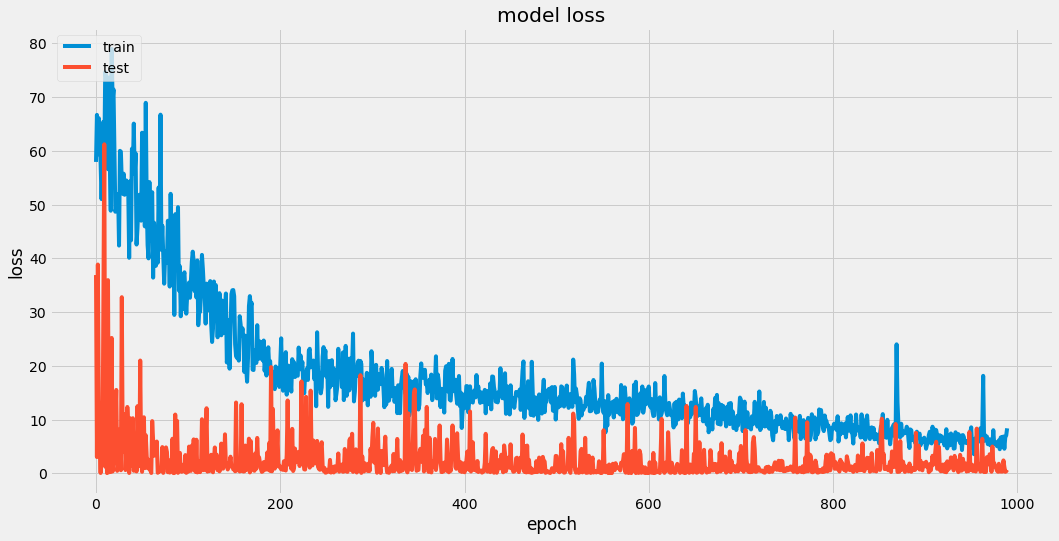

In [22]:
plt.figure(figsize = (16,8))
plt.plot(history.history['loss'][10:])
plt.plot(history.history['val_loss'][10:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


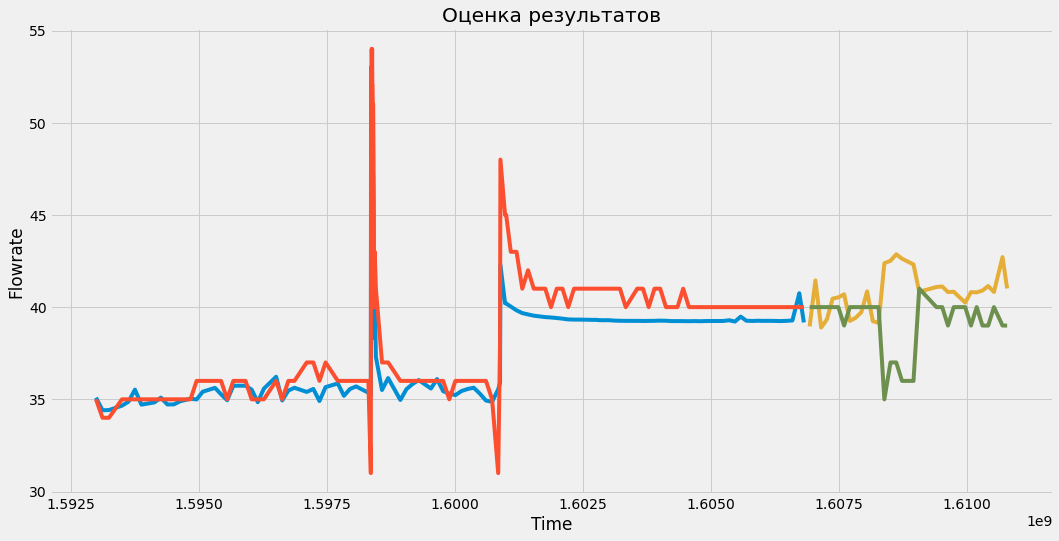

In [23]:
plt.figure(figsize = (16,8))
plt.plot(TIMES[:l], model.predict(x_train), '-', TIMES[:l], y_train, '-')
plt.plot(TIMES[l:], model.predict(x_test), '-', TIMES[l:], y_test, '-')
plt.title('Оценка результатов')
plt.xlabel('Time')
plt.ylabel('Flowrate')
plt.show()


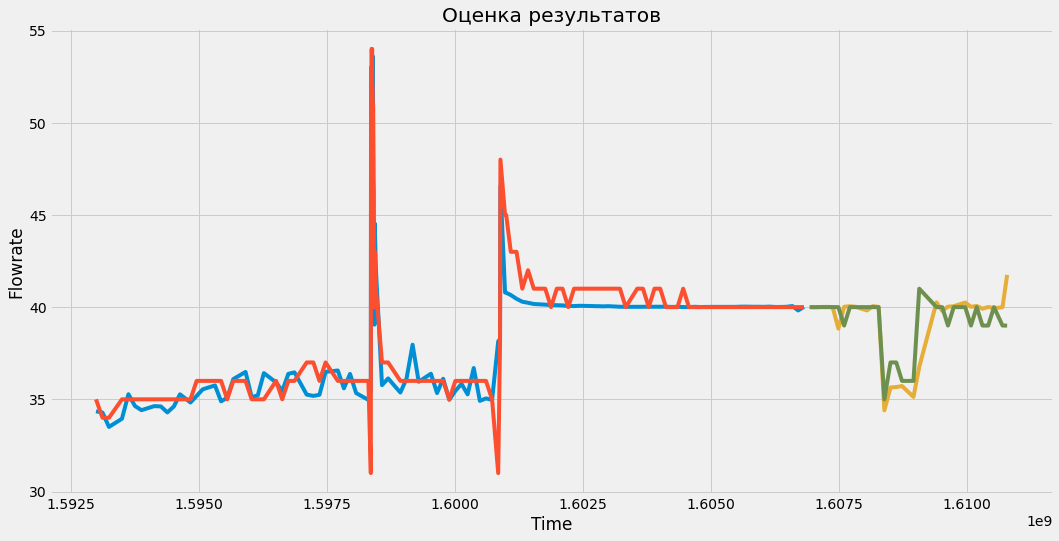

In [31]:
b_model = keras.models.load_model('C://Users/SMA_9/Desktop/OIS/models/LSTM_reg_1.h5')
plt.figure(figsize = (16,8))
plt.plot(TIMES[:l], b_model.predict(x_train), '-', TIMES[:l], y_train, '-')
plt.plot(TIMES[l:], b_model.predict(x_test), '-', TIMES[l:], y_test, '-')
plt.title('Оценка результатов')
plt.xlabel('Time')
plt.ylabel('Flowrate')
plt.show()
